In [1]:
from fl_puf.FederatedDataset.PartitionTypes.representative import Representative
import torch
from fl_puf.FederatedDataset.Utils.utils import PartitionUtils
from DPL.Utils.dataset_utils import DatasetUtils
from fl_puf.Utils.utils import Utils

/home/lcorbucci/fl_privacy_utility_fairness/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-08 11:30:26,590	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
train_set, test_set = DatasetUtils.download_dataset(
    "celeba",
    train_csv="original_merged",
    debug=True,
    base_path="./data/celeba",
)

In [3]:
train_path = Utils.prepare_dataset_for_FL(
    dataset=train_set,
    dataset_name="celeba",
    base_path="./data",
)

Generating unified dataset
Data Correctly downloaded


In [4]:
images, sensitive_attribute, labels = torch.load(train_path)
mapping = {-1: 0, 1: 1}
sensitive_attribute = torch.tensor([mapping[item] for item in sensitive_attribute])

idx = torch.tensor(list(range(len(images))))
dataset = [idx, sensitive_attribute, labels]
pool_size = 150
group_to_reduce = (1, 1)
group_to_increment = (0, 1)

Mean of disparity 0.4341470551671564 - std 0.07879454549656886


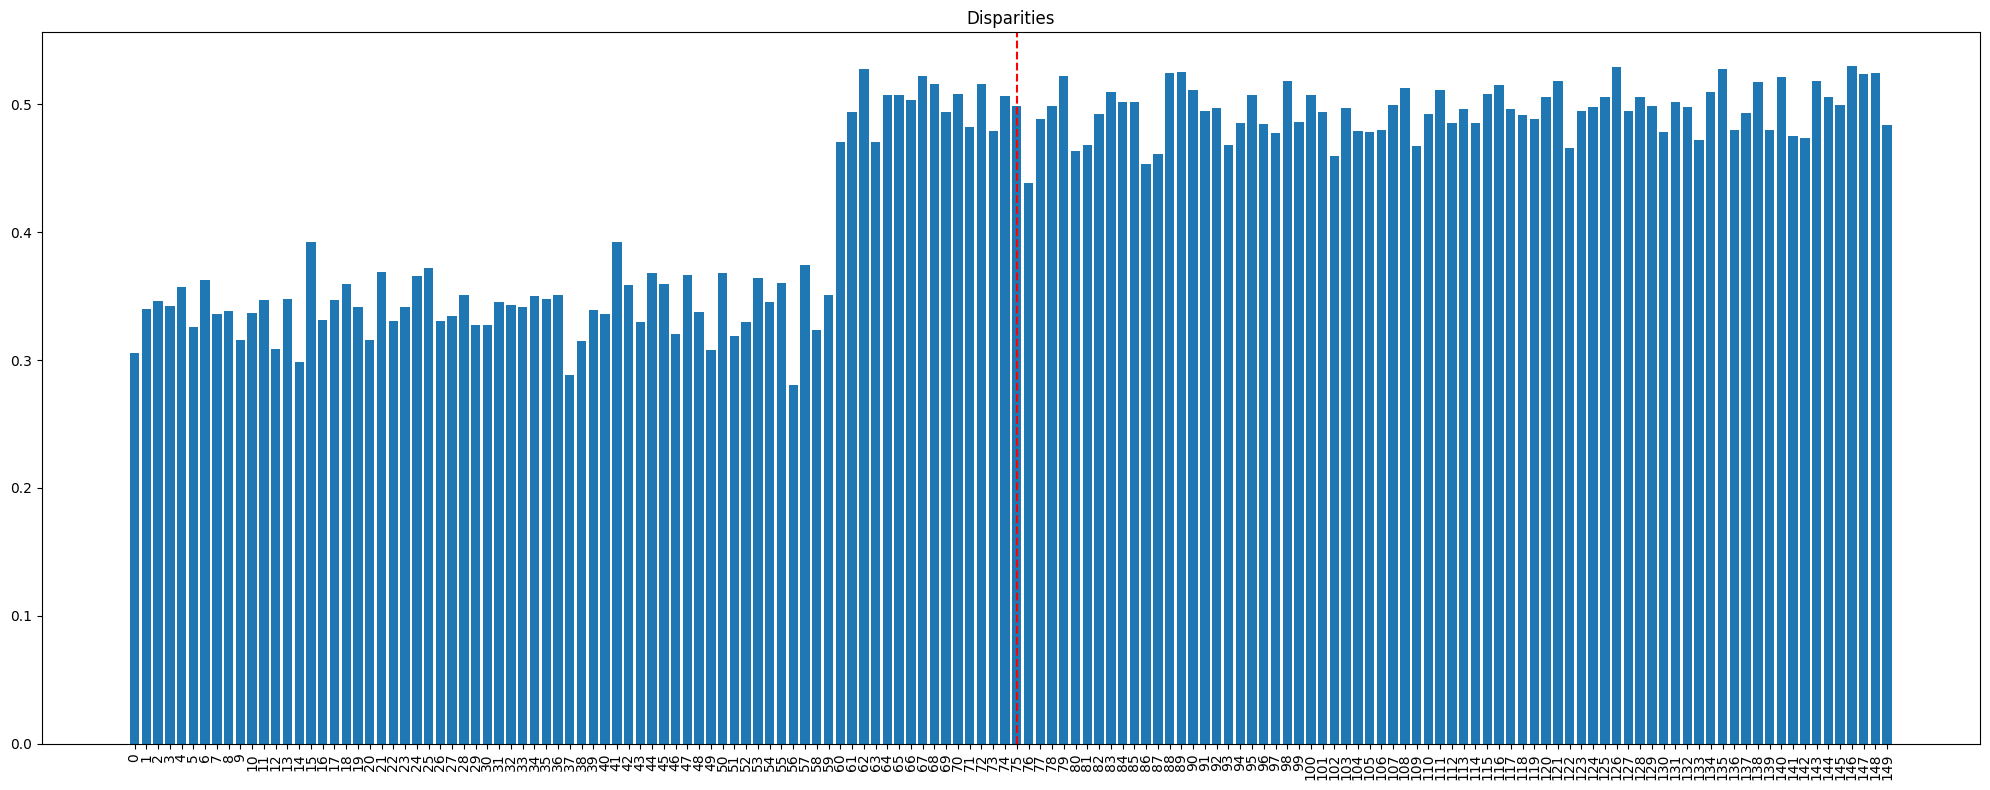

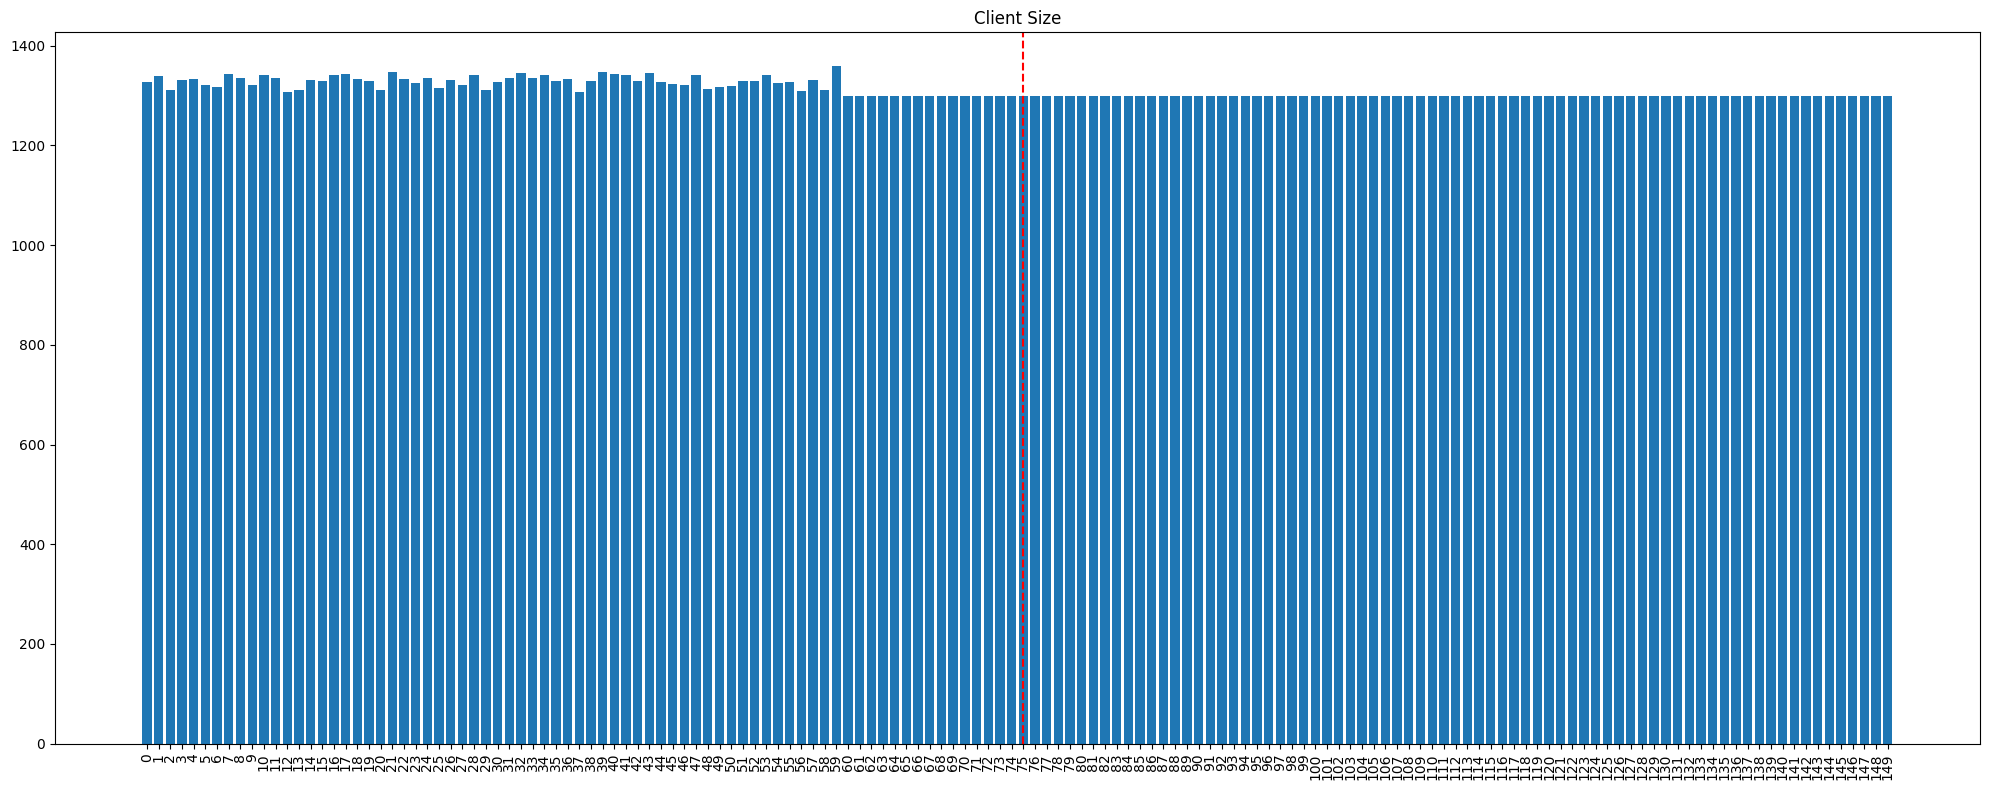

In [8]:
number_of_samples_per_node = 1300
ratio_unfair_nodes = 0.60
ratio_unfairness = (0.9, 0.9)

partitions_index_list, metadata = Representative.do_partitioning(
    labels=labels,
    sensitive_features=sensitive_attribute,
    num_partitions=pool_size,
    total_num_classes=2,
    group_to_reduce=group_to_reduce,
    group_to_increment=group_to_increment,
    number_of_samples_per_node=number_of_samples_per_node,
    ratio_unfair_nodes=ratio_unfair_nodes,
    ratio_unfairness=ratio_unfairness,
)
partitions = PartitionUtils.create_splitted_dataset_from_tuple(
    splitted_indexes=partitions_index_list,
    dataset=dataset,
)